In [11]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

from pathlib import Path
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import ccdproc as ccdp

from astropy.nddata import CCDData
from astropy.stats import mad_std
from astropy.timeseries import BinnedTimeSeries
import astropy.units as u
from convenience_functions import show_image

# suppress warnings is not recommended :I
import warnings
warnings.filterwarnings("ignore")

bias_dir = './data/bias'
flat_dir = './data/flat'
darks_dir = './data/dark'
tzboo_dir = './data/tz_boo'
cccom_dir = './data/cc_com'

cc_com_reduced = './data/cc_com/reduced/'
tz_boo_reduced = './data/tz_boo/reduced/'

pgf_plot = True

In [6]:
if pgf_plot:
    matplotlib.use('pgf')
else:
    matplotlib.use('module://matplotlib_inline.backend_inline')
    matplotlib.rcParams['backend']
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# What figures do we need
## Tables
- Bias, Dark, Flat data summary
- Comparison of fluxes from PSF, DAOSF, Aperture methods

## Figures
- Light Curves comparison (normalized)
- 

## Fit results from Yakut and Eggleton (2005)
- TZ Boo period: 0.297 [d]
- CC Com period: 0.221 [d]

Formula for fit: $$f(t) = 1 + \cos\left(\frac{2\pi}{P} (t + \phi) \right)$$

In [3]:
def lc_from_period(t, phase, period):
    return 0.5 * (1 + np.cos(2 * np.pi / period * (t - phase)))

## TZ Boo Plot

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


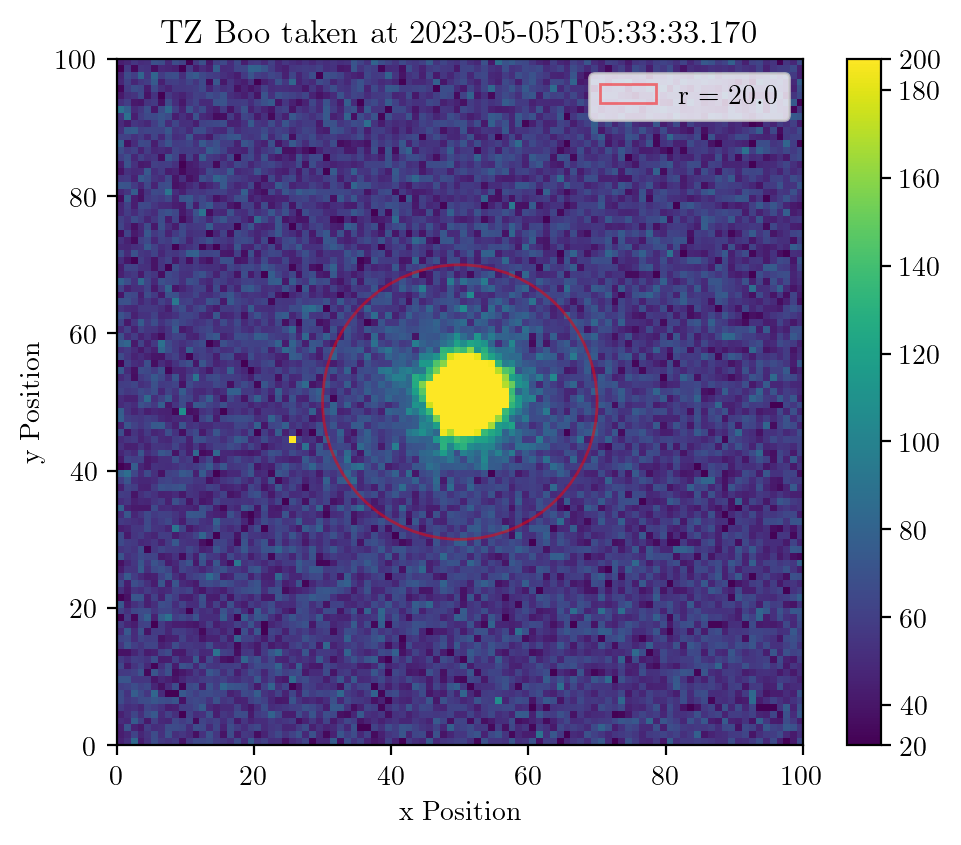

In [8]:
images = ImageFileCollection(tz_boo_reduced)
images = images.files_filtered(include_path=True)
fig, ax = plt.subplots()

image_data = CCDData.read(images[-1], unit='adu')
# print(np.median(image_data))
xcentroid = 1524
ycentroid = 1521
show_image(image_data.data[ycentroid-50:ycentroid+50, xcentroid-50:xcentroid+50], fig=fig, ax=ax, cmap='viridis');
aperture = CircularAperture(np.transpose((50, 50)), r=20.0)
aperture.plot(color='red', lw=1, alpha=0.5, label='r = 20.0')
fig.tight_layout();

ax.set_xlabel('x Position')
ax.set_ylabel('y Position')
date_obs = image_data.header['DATE-OBS']
ax.set_title(f'TZ Boo taken at {date_obs}')
ax.legend()
# ax.text(70, 70, 'r = 20.0', backgroundcolor='white')
if pgf_plot:
    fig.savefig('../paper/figures/tz-boo_reduced-example.pgf', format='pgf')
else:
    fig.savefig('../paper/figures/tz-boo_reduced-example.png', bbox_inches='tight')

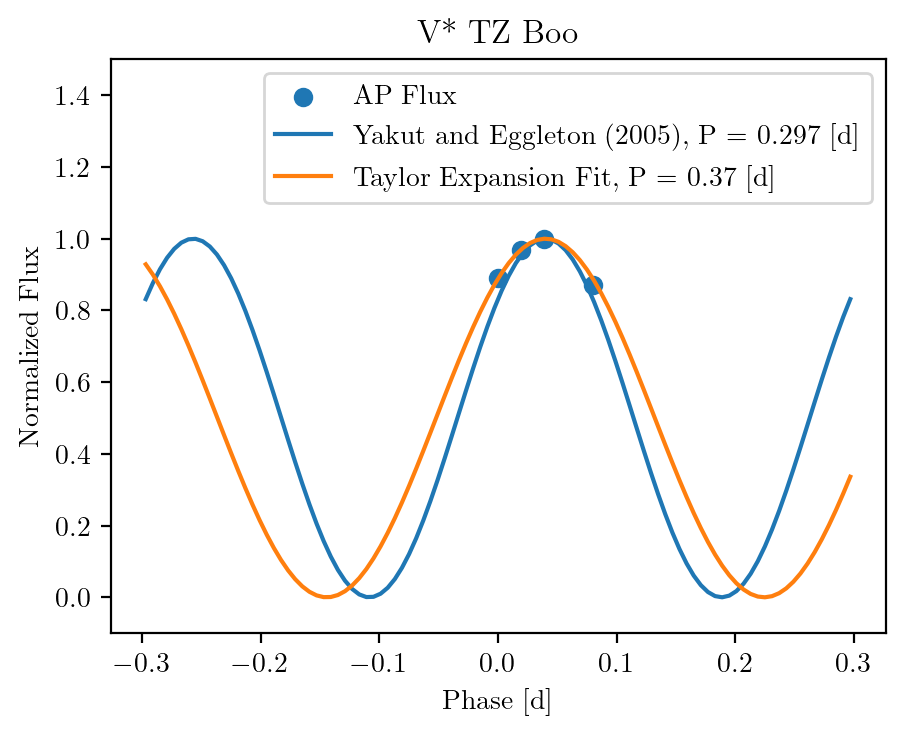

In [17]:
tz_fit = pd.read_csv('./results/tz_fit_params.csv')
tz_data = BinnedTimeSeries.read(
    './results/tzboo_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

tz_data = {
    'time' : tz_data.time_bin_start.jd - tz_data.time_bin_start.jd.min(),
    'ap flux' : tz_data['AP flux'] / tz_data['AP flux'].max()
}

tz_period_ye = 0.297
tz_period_fit = tz_fit['period'][0]

fig, ax = plt.subplots()

fit_domain = np.linspace(-1 * tz_period_ye, 1 * tz_period_ye, 100)
tz_curve_ye = lc_from_period(fit_domain, 0.04, tz_period_ye)
tz_curve_fit = lc_from_period(fit_domain, 0.04, tz_period_fit)

ax.scatter(tz_data['time'], tz_data['ap flux'], label='AP Flux')
ax.plot(fit_domain, tz_curve_ye, label=f'Yakut and Eggleton (2005), P = {tz_period_ye:.3} [d]')
ax.plot(fit_domain, tz_curve_fit, label=f'Taylor Expansion Fit, P = {tz_period_fit:.2} [d]')
ax.legend()
ax.set_xlabel('Phase [d]')
ax.set_ylabel('Normalized Flux')
ax.set_title('V* TZ Boo')
ax.set_ylim([-0.1, 1.5])
if pgf_plot:
    fig.set_size_inches(5,3.8)
    fig.savefig('../paper/figures/tz-boo_lightcurve.pgf', format='pgf')
else:
    fig.savefig('../paper/figures/tz-boo_lightcurve.png')

## CC Com plot

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


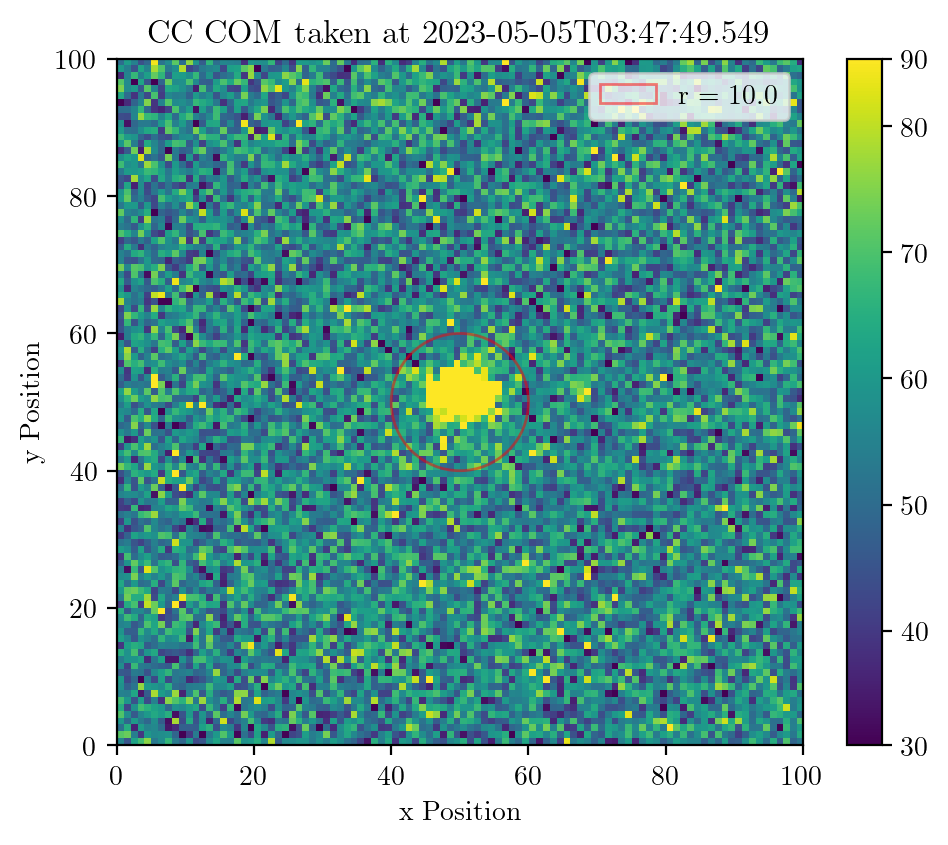

In [7]:
from photutils.aperture import CircularAperture

images = ImageFileCollection(cc_com_reduced)
images = images.files_filtered(include_path=True)
fig, ax = plt.subplots()

image_data = CCDData.read(images[0], unit='adu')
# print(np.median(image_data))
xcentroid = 1553
ycentroid = 1437
show_image(image_data.data[ycentroid-50:ycentroid+50, xcentroid-50:xcentroid+50], fig=fig, ax=ax, cmap='viridis');
aperture = CircularAperture(np.transpose((50, 50)), r=10.0)
aperture.plot(color='red', lw=1, alpha=0.5, label='r = 10.0')
fig.tight_layout();

ax.set_xlabel('x Position')
ax.set_ylabel('y Position')
ax.legend()
date_obs = image_data.header['DATE-OBS']
ax.set_title(f'CC COM taken at {date_obs}')
if pgf_plot:
    fig.savefig('../paper/figures/cc-com_reduced-example.pgf', format='pgf')
else:
    fig.savefig('../paper/figures/cc-com_reduced-example.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()

image_data = CCDData.read(images[1], unit='adu')
# print(np.median(image_data))
xcentroid = 1551
ycentroid = 1439
show_image(image_data.data[ycentroid-50:ycentroid+50, xcentroid-50:xcentroid+50], fig=fig, ax=ax, cmap='viridis');
aperture = CircularAperture(np.transpose((50, 50)), r=10.0)
aperture.plot(color='red', lw=1, alpha=0.5)
fig.tight_layout();

ax.set_xlabel('x Position')
ax.set_ylabel('y Position')
date_obs = image_data.header['DATE-OBS']
ax.set_title(f'CC COM taken at {date_obs}')

In [ ]:
fig, ax = plt.subplots()

image_data = CCDData.read(images[1], unit='adu')
# print(np.median(image_data))
xcentroid = 1550
ycentroid = 1439
show_image(image_data.data[ycentroid-50:ycentroid+50, xcentroid-50:xcentroid+50], fig=fig, ax=ax, cmap='viridis');
aperture = CircularAperture(np.transpose((50, 50)), r=10.0)
aperture.plot(color='red', lw=1, alpha=0.5)
fig.tight_layout();

ax.set_xlabel('x Position')
ax.set_ylabel('y Position')
date_obs = image_data.header['DATE-OBS']
ax.set_title(f'CC COM taken at {date_obs}')

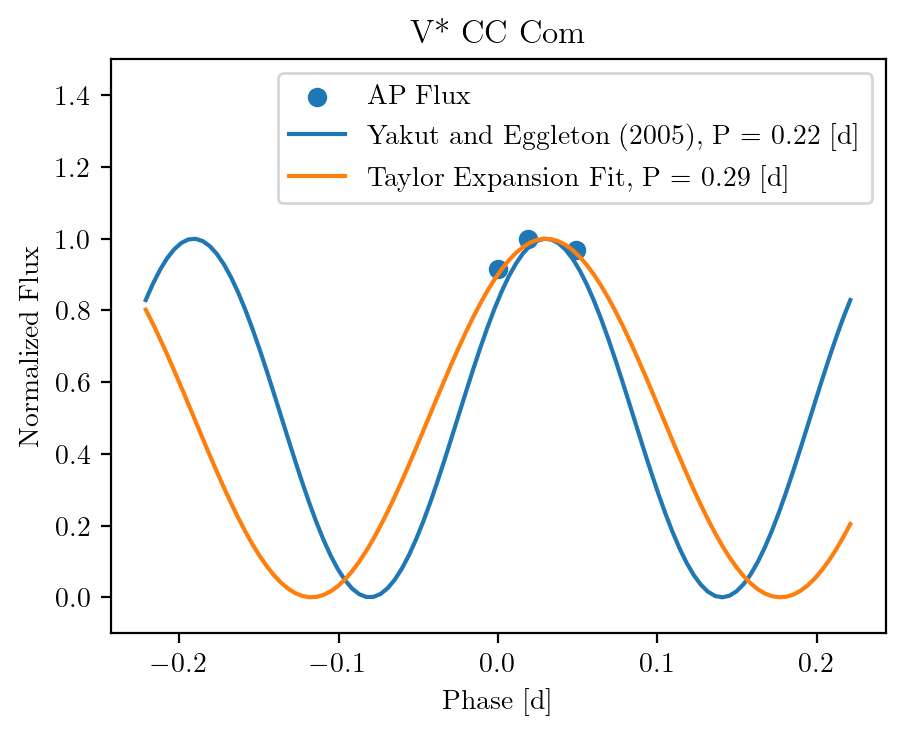

In [18]:
cc_fit = pd.read_csv('./results/cc_fit_params.csv')
cc_data = BinnedTimeSeries.read(
    './results/cccom_results.csv',
    time_bin_start_column='time_bin_start',
    time_bin_size_column='time_bin_size',
    time_bin_size_unit=u.s
)

cc_data = {
    'time' : cc_data.time_bin_start.jd - cc_data.time_bin_start.jd.min(),
    'ap flux' : cc_data['AP flux'] / cc_data['AP flux'].max()
}

cc_period_ye = 0.221
cc_period_fit = cc_fit['period'][0]
fig, ax = plt.subplots()

fit_domain = np.linspace(-1 * cc_period_ye, 1 * cc_period_ye, 100)
cc_curve_ye = lc_from_period(fit_domain, 0.03, cc_period_ye)
cc_curve_fit = lc_from_period(fit_domain, 0.03, cc_period_fit)

ax.scatter(cc_data['time'], cc_data['ap flux'], label='AP Flux')
ax.plot(fit_domain, cc_curve_ye, label=f'Yakut and Eggleton (2005), P = {cc_period_ye:.2} [d]')
ax.plot(fit_domain, cc_curve_fit, label=f'Taylor Expansion Fit, P = {cc_period_fit:.2} [d]')
ax.legend()
ax.set_xlabel('Phase [d]')
ax.set_ylabel('Normalized Flux')
ax.set_title('V* CC Com')
ax.set_ylim([-0.1, 1.5])

if pgf_plot:
    fig.set_size_inches(5,3.8)
    fig.savefig('../paper/figures/cc-com_lightcurve.pgf', format='pgf')
else:
    fig.savefig('../paper/figures/cc-com_lightcurve.png')